In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")

pd.options.mode.chained_assignment = None

import yfinance as yf

from datetime import datetime, timedelta

import os, os.path
os.chdir("/home/backstreet/use_backtest_bolt")

In [3]:
def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["daily_ret"]).cumprod()
    n = len(df)/252
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["daily_ret"].std() * np.sqrt(252)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["daily_ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd


In [4]:
def get_data(ticker):
    if not os.path.isfile(f'data/feathers/daily/{ticker}.feather'):
        ftr_data = yf.download(ticker, start=(datetime.now() - timedelta(days=10 * 365)), end=datetime.today())["Adj Close"].to_frame().dropna().reset_index()
        ftr_data.to_feather(f'data/feathers/daily/{ticker}.feather')
    raw = pd.read_feather(f'data/feathers/daily/{ticker}.feather')
    raw["Date"] = pd.to_datetime(raw["Date"])
    raw.set_index("Date", inplace=True)
    raw.dropna(inplace=True,how="all")
    return raw

In [5]:
# Download historical data (daily) for DJI constituent stocks

tickers = ["MMM","AXP","T","BA","CAT","CSCO","KO", "XOM","GE","GS","HD",
           "IBM","INTC","JNJ","JPM","MCD","MRK","MSFT","NKE","PFE","PG","TRV",
           "UNH","VZ","V","WMT","DIS"]

ohlc_mon = {} # directory with ohlc value for each stock

# looping over tickers and creating a dataframe with close prices
for ticker in tickers:
    ohlc_mon[ticker] = get_data(ticker)

tickers = ohlc_mon.keys() # redefine tickers variable after removing any tickers with corrupted data


In [6]:
################################ Backtesting ####################################

# calculating daily return for each stock and consolidating return info by stock in a separate dataframe
ohlc_dict = copy.deepcopy(ohlc_mon)
return_df = pd.DataFrame()
for ticker in tickers:
    # print("calculating daily return for ",ticker)
    ohlc_dict[ticker]["daily_ret"] = ohlc_dict[ticker]["Adj Close"].pct_change()
    return_df[ticker] = ohlc_dict[ticker]["daily_ret"]


In [7]:
# function to calculate portfolio return iteratively
def pflio(DF,m,x):
    """Returns cumulative portfolio return
    DF = dataframe with daily return info for all stocks
    m = number of stock in the portfolio
    x = number of underperforming stocks to be removed from portfolio daily"""
    df = DF.copy()
    portfolio = []
    daily_ret = [0]
    for i in range(len(df)):
        if len(portfolio) > 0:
            daily_ret.append(df[portfolio].iloc[i,:].mean())
            bad_stocks = df[portfolio].iloc[i,:].sort_values(ascending=True)[:x].index.values.tolist()
            portfolio = [t for t in portfolio if t not in bad_stocks]
        fill = m - len(portfolio)
        new_picks = df.iloc[i,:].sort_values(ascending=False)[:fill].index.values.tolist()
        portfolio = portfolio + new_picks
        # print(portfolio)
    daily_ret_df = pd.DataFrame(np.array(daily_ret),columns=["daily_ret"])
    return daily_ret_df


In [8]:
# calculating overall strategy's KPIs
CAGR(pflio(return_df,6,3))


0.05292250802437182

In [9]:
sharpe(pflio(return_df,6,3),0.025)


0.13901776829005671

In [10]:
max_dd(pflio(return_df,6,3))

0.455175996700317

In [11]:
# calculating KPIs for Index buy and hold strategy over the same period
DJI = get_data("^DJI")

In [12]:
DJI["daily_ret"] = DJI["Adj Close"].pct_change().fillna(0)

In [13]:
CAGR(DJI)

0.10733504295154939

In [14]:
sharpe(DJI,0.025)

0.4688279757845527

In [15]:
max_dd(DJI)

0.3708617136959432

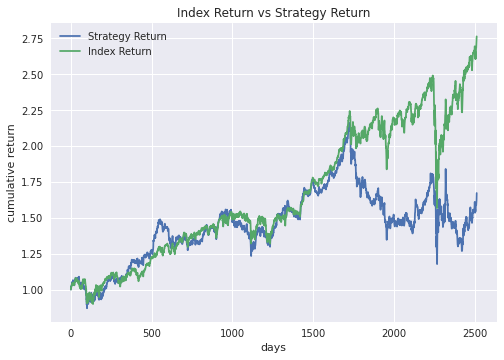

In [16]:
# visualization
fig, ax = plt.subplots()
plt.plot((1+pflio(return_df,6,3)).cumprod())
plt.plot((1+DJI["daily_ret"].reset_index(drop=True)).cumprod())
plt.title("Index Return vs Strategy Return")
plt.ylabel("cumulative return")
plt.xlabel("days")
ax.legend(["Strategy Return","Index Return"])